<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Image Classification using CNNs in TensorFlow

**Notes:**  
- This notebook should be run on GPU.

In [1]:
# Run this cell only if working in Colab
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI540-Deep-Learning-Applications" # Enter repo name
git_path = 'https://github.com/AIPI540/AIPI540-Deep-Learning-Applications.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Change working directory to location of notebook
notebook_dir = '2_computer_vision/CNNs'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

Cloning into 'AIPI540-Deep-Learning-Applications'...
remote: Enumerating objects: 1782, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 1782 (delta 94), reused 163 (delta 65), pack-reused 1580
Receiving objects: 100% (1782/1782), 345.11 MiB | 27.18 MiB/s, done.
Resolving deltas: 100% (652/652), done.
Updating files: 100% (555/555), done.
/content/AIPI540-Deep-Learning-Applications/2_computer_vision/CNNs
3d_classification.ipynb  data/    simple_resnet.ipynb
cnn_basics.ipynb         img/     transfer_learning.ipynb
cnn_w_tensorboard.ipynb  models/  xrays_example.ipynb


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Load Data

In [3]:
# Load training and test data
if not os.path.exists('./data'):
    os.mkdir('./data')

# Set up datasets
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

print('Training data images: ', len(train_images))
print('Test data images: ', len(test_images))

# Specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Set random seed for reproducibility
tf.random.set_seed(0)

4422102/4422102 [==============================] - 0s 0us/step
Training data images:  60000
Test data images:  10000


## Step 1: Set up dataloaders for our data

In [4]:
batch_size = 16

# Prepare the datasets for training and testing
train_loader = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(10000).batch(batch_size)
test_loader = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

(16, 28, 28)


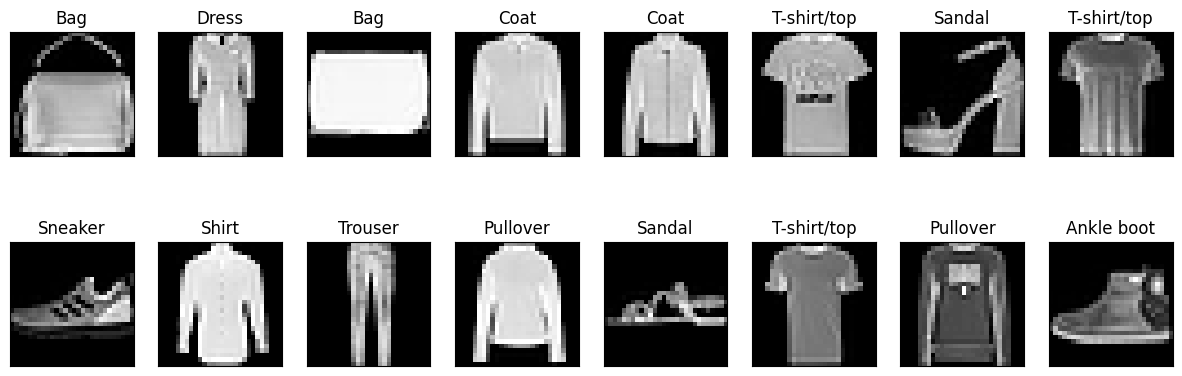

In [6]:
# Get next batch of training images
for images, labels in train_loader.take(1):
    print(images.shape)
    images = images.numpy()

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(15, 5))
    for idx in range(batch_size):
        ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.set_title(classes[labels[idx]])

## Step 2: Design and Compile CNN Model using Sequential API

#### Differences between TF and PyTorch on tensor format

**TensorFlow:**

* TensorFlow typically uses the "channels last" format for its tensors, especially when dealing with image data.
* For a 2D image, the shape is often represented as [Height, Width, Channels].
* So, if you have an image that is 28x28 pixels in grayscale (1 channel), TensorFlow would represent this as [28, 28, 1].
* This format is more intuitive for people who work with image processing as it follows the conventional way of thinking about images (width by height by color channels).

**PyTorch:**

* PyTorch, on the other hand, usually adopts the "channels first" format for its tensors.
* For a 2D image, the shape is represented as [Channels, Height, Width].
* So, the same 28x28 pixels grayscale image would be represented in PyTorch as [1, 28, 28].
* This format is often preferred in the context of machine learning and deep learning because it can lead to more efficient memory access patterns during computation on GPUs.

In [7]:
# Define the model using the Sequential API
model = tf.keras.models.Sequential([
    # Note: Input shape [28, 28, 1] for TensorFlow (channel last format)
    tf.keras.layers.Conv2D(10, (3, 3), strides=(1, 1), padding='valid', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(20, (3, 3), strides=(1, 1), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(classes)) #You want the output to be equal to the number of classes
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 10)        100       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 10)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 20)        1820      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 20)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 500)               0         
                                                                 
 dense (Dense)               (None, 10)                5

## Step 3: Train the Model

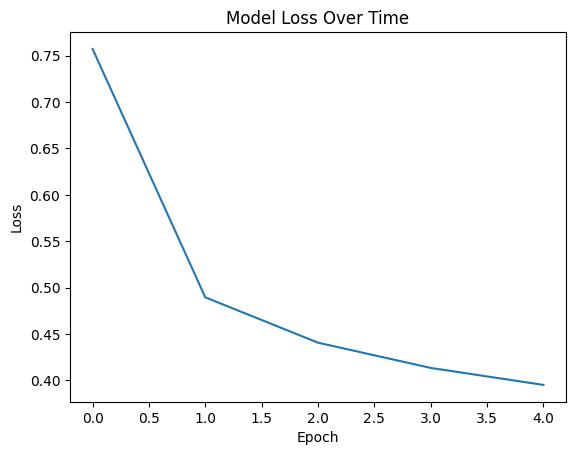

In [8]:
n_epochs = 5

history = model.fit(train_loader, epochs=n_epochs, verbose=0)

# loss curve
plt.plot(history.history['loss'])
plt.title('Model Loss Over Time')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Step 4: Test the model on the test set

In [9]:
from sklearn.metrics import recall_score

def test_model(model, test_loader):

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_loader, verbose=0)

    # Initialize lists for true labels and predictions
    y_true = []
    test_preds = []

    # Predict on the test set
    for inputs, labels in test_loader:
        # Predict probabilities for each class
        probs = model.predict(inputs)
        # Convert probabilities to discrete predictions
        preds = np.argmax(probs, axis=1)
        # Append predictions and actuals to the lists
        test_preds.extend(preds)
        y_true.extend(labels.numpy())

    # Convert the lists to arrays for further analysis
    test_preds = np.array(test_preds)
    y_true = np.array(y_true)

    # Calculate recall for each class
    recall_vals = recall_score(y_true, test_preds, average=None)

    return test_acc, recall_vals



acc, recall_vals = test_model(model, test_loader)
print('Test set accuracy is {:.3f}'.format(acc))
for i, recall_val in enumerate(recall_vals):
    print('For class {}, recall is {}'.format(classes[i], recall_val))

1/1 [==============================] - 0s 23ms/step
Test set accuracy is 0.848
For class T-shirt/top, recall is 0.74
For class Trouser, recall is 0.968
For class Pullover, recall is 0.618
For class Dress, recall is 0.854
For class Coat, recall is 0.892
For class Sandal, recall is 0.961
For class Shirt, recall is 0.612
For class Sneaker, recall is 0.929
For class Bag, recall is 0.956
For class Ankle boot, recall is 0.951


1/1 [==============================] - 0s 25ms/step


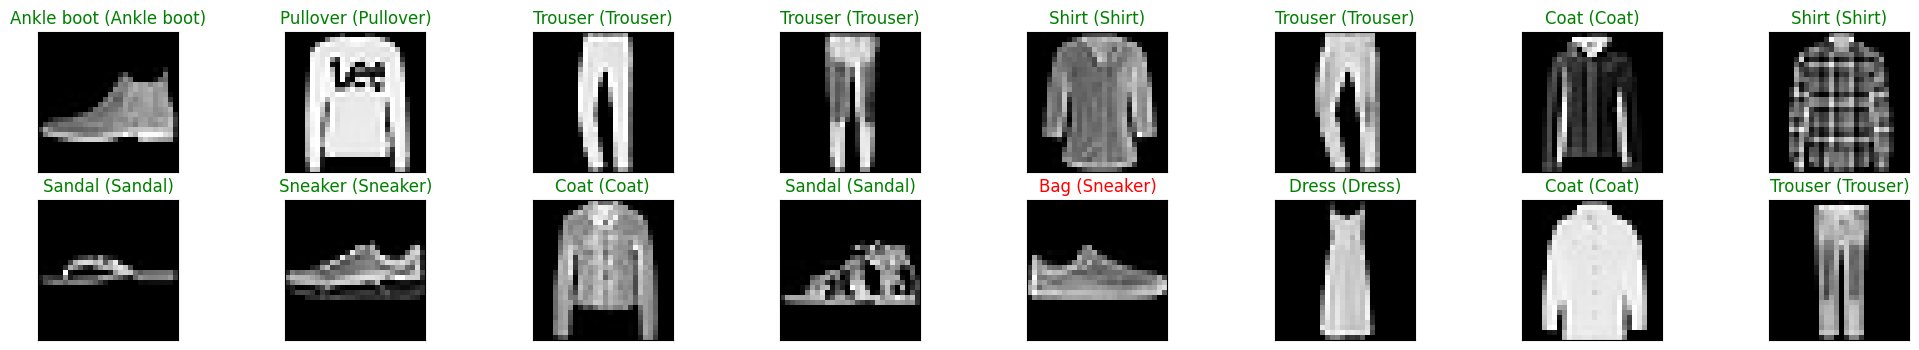

In [10]:
# Display a batch of predictions
for images, labels in test_loader.take(1):  # Take 1 batch from the dataset
    # get predictions
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)

    images = images.numpy()  # Convert tensors to numpy arrays
    labels = labels.numpy()

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in range(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    # Assuming images are grayscale, if not, you'll need to adjust the dimension indexing
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx] == labels[idx] else "red"))
plt.show()